# 04 - Comparación de Modelos de Clasificación

En este notebook se comparan los distintos modelos de clasificación entrenados en los pasos anteriores,  
con el objetivo de identificar cuál ofrece el **mejor rendimiento global** y mayor capacidad de generalización.


### 🎯 **Objetivos:**

- Cargar automáticamente los resultados de los modelos guardados en `../reports/metrics/`.  
- Consolidar las métricas clave: **Accuracy**, **Precision**, **Recall**, **F1-score** y **ROC-AUC**.  
- Calcular un **score medio global** para facilitar la comparación entre modelos y tunings.  
- Visualizar los resultados mediante:
  - Gráficos de barras agrupadas  
  - Gráfico radar de métricas  
  - Curvas ROC comparativas (si se dispone de los modelos `.pkl`)  
- Exportar un resumen global de resultados a:
  - `../reports/results/model_comparison_summary.csv`  
  - `../reports/metrics/model_comparison_summary.json`  


📘 **Nota:**  
Todos los archivos de resultados provienen de los notebooks individuales  
donde se realizó el **tuning de hiperparámetros** y la **evaluación sobre el conjunto de test**.  
Estos resultados serán la base para seleccionar el modelo más prometedor  
que se evaluará finalmente en el notebook `05_Test-Set-Final.ipynb`.


## **Paso 1: Importación de librerías y configuración general**

En este primer paso se importan las librerías necesarias para el análisis y visualización de resultados,  
y se configura el entorno gráfico con un estilo uniforme para todos los gráficos.

Además, se definen las rutas de trabajo donde se almacenan los resultados y modelos:
- `../reports/metrics/` → métricas individuales de cada modelo y tuning.  
- `../reports/results/` → resúmenes comparativos finales.  

El notebook comprobará automáticamente si estos directorios existen antes de continuar.


In [105]:
# ===================================
# 1. Importación de librerías y configuración general
# ===================================

import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import pi
from IPython.display import display, Markdown

# --- Configuración visual ---
plt.style.use("default")
sns.set_palette("coolwarm")
plt.rcParams.update({
    "axes.facecolor": "white",
    "axes.edgecolor": "#B0BEC5",
    "axes.labelcolor": "#263238",
    "axes.titlesize": 13,
    "axes.titlecolor": "#0D47A1",
    "grid.alpha": 0.3,
    "grid.linestyle": "--",
    "grid.linewidth": 0.5
})

# --- Rutas ---
metrics_dir = "../reports/metrics/"
results_dir = "../reports/results/"

# --- Verificación de directorios ---
os.makedirs(results_dir, exist_ok=True)

if not os.path.exists(metrics_dir):
    display(Markdown(f"⚠️ **Directorio de métricas no encontrado:** `{metrics_dir}`"))
else:
    display(Markdown(f"✅ **Directorio de métricas detectado:** `{metrics_dir}`"))

display(Markdown("""
**💡 Configuración completada.**  
En el siguiente paso se cargarán todas las métricas guardadas (`.json`)  
de los distintos modelos y tunings para generar una tabla comparativa.
"""))


✅ **Directorio de métricas detectado:** `../reports/metrics/`


**💡 Configuración completada.**  
En el siguiente paso se cargarán todas las métricas guardadas (`.json`)  
de los distintos modelos y tunings para generar una tabla comparativa.


## **Paso 2: Carga dinámica de métricas de los modelos**

En este paso, se recorren todos los ficheros `.json` ubicados en la carpeta `../reports/metrics/`  
y se extrae de cada uno la información relevante del modelo y sus resultados de evaluación.

De esta forma, se construye una tabla comparativa con las métricas clave de cada modelo:
**Accuracy, Precision, Recall, F1-score y ROC-AUC.**

Esto permite añadir nuevos modelos o tunings sin necesidad de modificar el código,
ya que el proceso es completamente **dinámico y automatizado**.


In [106]:
# ===================================
# 2. Carga dinámica de métricas desde JSON (versión final robusta)
# ===================================

all_metrics = []

for file in os.listdir(metrics_dir):
    if file.endswith(".json"):
        path = os.path.join(metrics_dir, file)
        try:
            with open(path, "r") as f:
                data = json.load(f)
                model_name = file.replace("_metrics.json", "").replace(".json", "")

                # --- Extraer sólo las métricas relevantes ---
                flat_data = {
                    "Model": model_name,
                    "Accuracy": data.get("Accuracy"),
                    "Precision": data.get("Precision"),
                    "Recall": data.get("Recall"),
                    "F1-score": data.get("F1-score"),
                    "ROC-AUC": data.get("ROC-AUC"),
                }

                all_metrics.append(flat_data)
        except Exception as e:
            print(f"❌ Error al leer {file}: {e}")

# --- Construcción del DataFrame ---
comparison_df = pd.DataFrame(all_metrics)

# --- Forzar conversión a numérico para columnas de métricas ---
metric_cols = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
for col in metric_cols:
    comparison_df[col] = pd.to_numeric(comparison_df[col], errors="coerce")

# --- Eliminar filas sin métricas válidas ---
comparison_df = comparison_df.dropna(subset=["F1-score"]).reset_index(drop=True)

# --- Redondear valores numéricos ---
comparison_df[metric_cols] = comparison_df[metric_cols].round(3)

# --- Mostrar resultado de forma segura ---
display(Markdown("### 📋 **Métricas cargadas correctamente:**"))
display(comparison_df)


### 📋 **Métricas cargadas correctamente:**

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
0,knn_baseline,0.926,0.935,0.893,0.913,0.970
1,knn_gridsearch,0.938,0.943,0.911,0.927,0.981
2,knn_optuna,0.936,0.943,0.908,0.925,0.983
3,random_forest_baseline,0.961,0.967,0.943,0.955,0.994
4,random_forest_gridsearch,0.961,0.962,0.946,0.954,0.959
5,random_forest_optuna,0.962,0.967,0.944,0.955,0.960
6,random_forest_randomized,0.961,0.968,0.942,0.955,0.959
7,xgboost_baseline,0.961,0.958,0.952,0.955,0.995
8,xgboost_gridsearch,0.963,0.961,0.954,0.957,0.995
9,xgboost_optuna,0.965,0.971,0.947,0.959,0.995


In [107]:
# ===================================
# 1. Importación de librerías y carga de resultados
#    de métricas desde reports/metrics/
# ===================================

import os
import json
import shutil
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# --- Configuración visual ---
sns.set(style="whitegrid")
plt.rcParams["axes.titlesize"] = 13
plt.rcParams["axes.labelsize"] = 11

# --- Directorios ---
metrics_dir = "../reports/metrics/"
results_dir = "../reports/results/"
os.makedirs(results_dir, exist_ok=True)

if not os.path.exists(metrics_dir):
    raise FileNotFoundError(f"La carpeta {metrics_dir} no existe. Verifica la ruta.")

# --- Archivos disponibles ---
metric_files = [f for f in os.listdir(metrics_dir) if f.endswith(".json")]
if not metric_files:
    raise FileNotFoundError("No se encontraron archivos .json en reports/metrics/. Ejecuta primero los notebooks de modelos.")

results = []
moved_summaries = []

for file in metric_files:
    file_path = os.path.join(metrics_dir, file)

    # Mover summaries si están mal ubicados
    if "summary" in file.lower():
        shutil.move(file_path, os.path.join(results_dir, file))
        moved_summaries.append(file)
        continue

    try:
        with open(file_path, "r") as f:
            data = json.load(f)

            # --- Detección automática del formato ---
            if "metrics" in data:
                metrics = data["metrics"]
                model_name = data.get("model", os.path.splitext(file)[0])
            else:
                # formato antiguo: métricas en nivel raíz
                metrics = {
                    k: v for k, v in data.items()
                    if isinstance(v, (int, float)) and k.lower() in 
                    ["accuracy", "precision", "recall", "f1-score", "roc-auc"]
                }
                model_name = data.get("model", os.path.splitext(file)[0])

            # --- Validar métricas ---
            if not metrics:
                print(f"⚠️ Archivo ignorado (sin métricas válidas): {file}")
                continue

            results.append({
                "Model": model_name,
                "Accuracy": metrics.get("Accuracy"),
                "Precision": metrics.get("Precision"),
                "Recall": metrics.get("Recall"),
                "F1-score": metrics.get("F1-score"),
                "ROC-AUC": metrics.get("ROC-AUC")
            })

    except Exception as e:
        print(f"⚠️ Error leyendo {file}: {e}")

# --- Crear DataFrame consolidado ---
df_results = pd.DataFrame(results)

# --- Forzar tipos numéricos ---
metric_cols = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
for col in metric_cols:
    df_results[col] = pd.to_numeric(df_results[col], errors="coerce")

# --- Filtrar métricas válidas ---
df_results = df_results.dropna(subset=["Accuracy", "F1-score"], how="any")

# --- Calcular score medio ---
df_results["mean_score"] = df_results[metric_cols].mean(axis=1)

# --- Ordenar de mejor a peor ---
df_results = df_results.sort_values(by="mean_score", ascending=False).reset_index(drop=True)

# --- Guardar resultados consolidados en ../reports/results/ ---
csv_path = os.path.join(results_dir, "model_comparison_results.csv")
json_path = os.path.join(results_dir, "model_comparison_results.json")

df_results.to_csv(csv_path, index=False)
with open(json_path, "w") as f:
    json.dump(results, f, indent=4)

# --- Mostrar tabla ordenada ---
display(Markdown("### 📊 **Modelos cargados con métricas válidas (ordenados por rendimiento promedio):**"))
display(
    df_results.style
    .format("{:.3f}", subset=metric_cols + ["mean_score"])
    .set_caption("📈 Comparación de métricas por modelo (valores redondeados)")
    .highlight_max(color="#3c4c6e", axis=0)
)

# --- Mensaje final ---
moved_msg = f"\n📂 Se movieron {len(moved_summaries)} archivos 'summary' a ../reports/results/." if moved_summaries else ""
display(Markdown(f"""
✅ **Resultados combinados guardados correctamente:**
- `{csv_path}`
- `{json_path}`

{moved_msg}

💬 **Notas:**
- Solo se incluyen modelos con métricas completas y válidas.  
- Los archivos de resumen global ahora se guardan en `../reports/results/`.  
- Las celdas resaltadas indican los mejores valores por métrica.
"""))


### 📊 **Modelos cargados con métricas válidas (ordenados por rendimiento promedio):**

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC,mean_score
0,xgboost_optuna_metrics,0.965,0.971,0.947,0.959,0.995,0.967
1,xgboost_gridsearch_metrics,0.963,0.961,0.954,0.957,0.995,0.966
2,xgboost_baseline_metrics,0.961,0.958,0.952,0.955,0.995,0.964
3,random_forest_baseline_metrics,0.961,0.967,0.943,0.955,0.994,0.964
4,random_forest_optuna_metrics,0.962,0.967,0.944,0.955,0.960,0.958
5,random_forest_randomized_metrics,0.961,0.968,0.942,0.955,0.959,0.957
6,random_forest_gridsearch_metrics,0.961,0.962,0.946,0.954,0.959,0.956
7,Decision Tree (optuna),0.950,0.950,0.934,0.942,0.986,0.953
8,Decision Tree (gridsearchcv),0.950,0.944,0.942,0.943,0.980,0.952
9,Decision Tree (baseline),0.945,0.933,0.941,0.937,0.945,0.940



✅ **Resultados combinados guardados correctamente:**
- `../reports/results/model_comparison_results.csv`
- `../reports/results/model_comparison_results.json`



💬 **Notas:**
- Solo se incluyen modelos con métricas completas y válidas.  
- Los archivos de resumen global ahora se guardan en `../reports/results/`.  
- Las celdas resaltadas indican los mejores valores por métrica.


## **Paso 3: Consolidación y comparación de modelos**

En este paso se agrupan y comparan todas las métricas cargadas desde los archivos JSON.  
Se calcula un **promedio global** (`Mean_Score`) combinando las métricas principales:
**Accuracy**, **Precision**, **Recall**, **F1-score** y **ROC-AUC**.

Este valor permite ordenar los modelos según su rendimiento global,  
identificando de forma rápida los mejores candidatos para la fase final.

También se verifica la integridad de los datos, asegurando que solo se incluyan modelos válidos.



In [108]:
# ===================================
# 3. Consolidación y comparación de modelos
# ===================================

# --- Verificar que df_results existe y contiene datos ---
if "df_results" not in locals() or df_results.empty:
    raise ValueError("❌ No se encontró el DataFrame 'df_results'. Ejecuta el Paso 2 primero.")

display(Markdown("### 📊 Consolidación de métricas por modelo"))

# --- Reforzar tipos numéricos ---
metric_cols = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]
for col in metric_cols:
    df_results[col] = pd.to_numeric(df_results[col], errors="coerce")

# --- Eliminar posibles duplicados ---
df_results = df_results.drop_duplicates(subset=["Model"])

# --- Calcular el promedio global ---
df_results["Mean_Score"] = df_results[metric_cols].mean(axis=1)

# --- Ordenar de mejor a peor modelo ---
df_results = df_results.sort_values(by="Mean_Score", ascending=False).reset_index(drop=True)

# --- Crear tabla visual con índice amigable ---
df_display = df_results.copy()
df_display.index = [f"#{i+1}" for i in range(len(df_display))]

# --- Mostrar tabla consolidada ---
display(
    df_display.style
    .format("{:.3f}", subset=metric_cols + ["Mean_Score"])
    .set_caption("📈 Consolidación de métricas y rendimiento promedio por modelo")
    .highlight_max(color="#3c4c6e", axis=0)
)

# --- Interpretación ---
display(Markdown("""
💬 **Interpretación de resultados:**
- Los modelos están ordenados de mayor a menor rendimiento promedio.  
- El **Mean_Score** combina las métricas más relevantes para una visión global.  
- Las celdas en azul destacan los valores máximos por métrica.  
- Los modelos con altos valores en **F1-score** y **ROC-AUC** suelen considerarse más equilibrados.
"""))


### 📊 Consolidación de métricas por modelo

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC,mean_score,Mean_Score
#1,xgboost_optuna_metrics,0.965,0.971,0.947,0.959,0.995,0.967247,0.967
#2,xgboost_gridsearch_metrics,0.963,0.961,0.954,0.957,0.995,0.966054,0.966
#3,xgboost_baseline_metrics,0.961,0.958,0.952,0.955,0.995,0.964315,0.964
#4,random_forest_baseline_metrics,0.961,0.967,0.943,0.955,0.994,0.963937,0.964
#5,random_forest_optuna_metrics,0.962,0.967,0.944,0.955,0.960,0.957529,0.958
#6,random_forest_randomized_metrics,0.961,0.968,0.942,0.955,0.959,0.957164,0.957
#7,random_forest_gridsearch_metrics,0.961,0.962,0.946,0.954,0.959,0.956422,0.956
#8,Decision Tree (optuna),0.950,0.950,0.934,0.942,0.986,0.952749,0.953
#9,Decision Tree (gridsearchcv),0.950,0.944,0.942,0.943,0.980,0.951821,0.952
#10,Decision Tree (baseline),0.945,0.933,0.941,0.937,0.945,0.940187,0.940



💬 **Interpretación de resultados:**
- Los modelos están ordenados de mayor a menor rendimiento promedio.  
- El **Mean_Score** combina las métricas más relevantes para una visión global.  
- Las celdas en azul destacan los valores máximos por métrica.  
- Los modelos con altos valores en **F1-score** y **ROC-AUC** suelen considerarse más equilibrados.


## **Paso 4: Visualización comparativa del rendimiento entre modelos**

En este paso se representan visualmente los resultados consolidados para facilitar la interpretación:

- 📊 **Gráfico de barras** con las principales métricas de rendimiento (`Accuracy`, `Precision`, `Recall`, `F1-score`, `ROC-AUC`).
- 🕸️ **Gráfico radar** que resume el perfil de cada modelo de manera equilibrada.

Cada color representa un modelo distinto, y el objetivo es identificar visualmente:
- Cuáles son los modelos con mejor equilibrio general.
- En qué métricas destaca cada uno.

Finalmente, se exportan los gráficos a la carpeta `../reports/figures/` para su inclusión en informes posteriores.


### 📊 Comparación visual de métricas por modelo

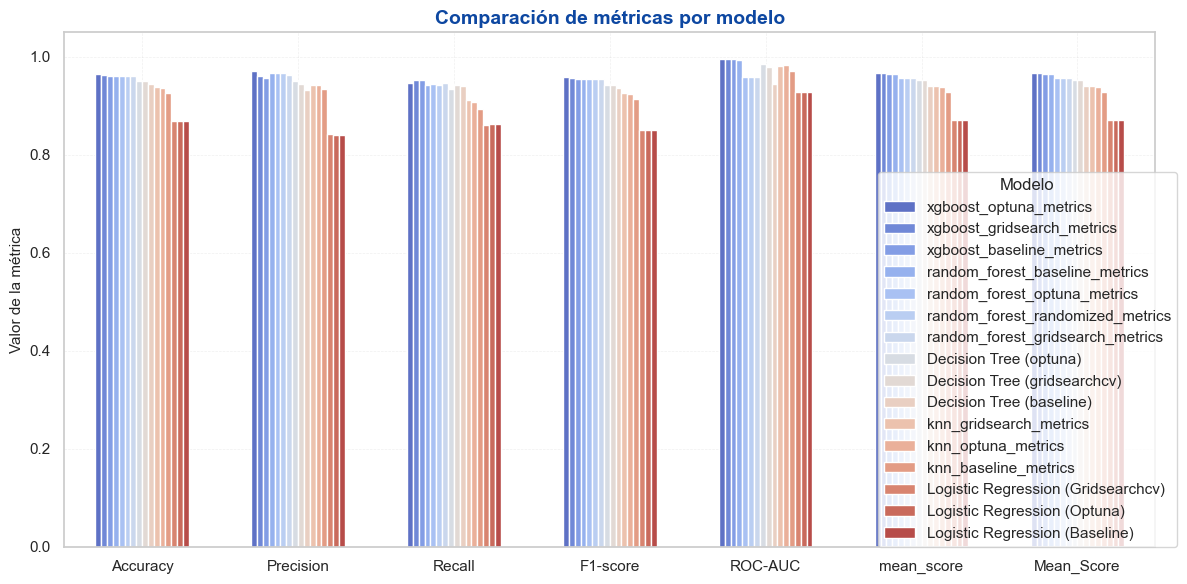


💬 **Interpretación de los gráficos:**
- Cada grupo de barras corresponde a una métrica específica.  
- Los modelos con barras más altas en la mayoría de las métricas tienen mejor rendimiento global.  
- Si un modelo destaca solo en una métrica (por ejemplo, alta precisión pero bajo recall),  
  podría ser más sensible a desbalanceo o sobreajuste.  
- Los modelos equilibrados tienden a mantener alturas similares entre métricas.


In [109]:
# ===================================
# 4. Visualización comparativa del rendimiento
# ===================================

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

display(Markdown("### 📊 Comparación visual de métricas por modelo"))

# --- Verificación ---
if "df_results" not in locals() or df_results.empty:
    raise ValueError("❌ No se encontraron resultados de métricas. Ejecuta los pasos anteriores primero.")

# --- Reformatear los datos para gráfico agrupado ---
df_melted = df_results.melt(id_vars="Model", var_name="Métrica", value_name="Valor")

# --- Configuración de la paleta y estilo ---
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_melted,
    x="Métrica",
    y="Valor",
    hue="Model",
    palette="coolwarm",
    width=0.6
)

# --- Personalización visual ---
plt.title("Comparación de métricas por modelo", fontsize=14, weight="bold")
plt.xlabel("")
plt.ylabel("Valor de la métrica", fontsize=11)
plt.ylim(0, 1.05)
plt.legend(
    title="Modelo",
    loc="lower right",
    bbox_to_anchor=(1.02, 0),
    borderaxespad=0,
    frameon=True
)
plt.grid(alpha=0.3, linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.show()

display(Markdown("""
💬 **Interpretación de los gráficos:**
- Cada grupo de barras corresponde a una métrica específica.  
- Los modelos con barras más altas en la mayoría de las métricas tienen mejor rendimiento global.  
- Si un modelo destaca solo en una métrica (por ejemplo, alta precisión pero bajo recall),  
  podría ser más sensible a desbalanceo o sobreajuste.  
- Los modelos equilibrados tienden a mantener alturas similares entre métricas.
"""))


## **Paso 5: Gráfico radar de comparación global**

El gráfico radar (o de araña) permite comparar visualmente el rendimiento global de los modelos  
en las cinco métricas principales: **Accuracy**, **Precision**, **Recall**, **F1-score** y **ROC-AUC**.

Cada modelo se representa mediante un polígono de color distinto,  
lo que permite identificar de un vistazo cuál mantiene un mejor equilibrio general  
y cuál sobresale en métricas específicas.

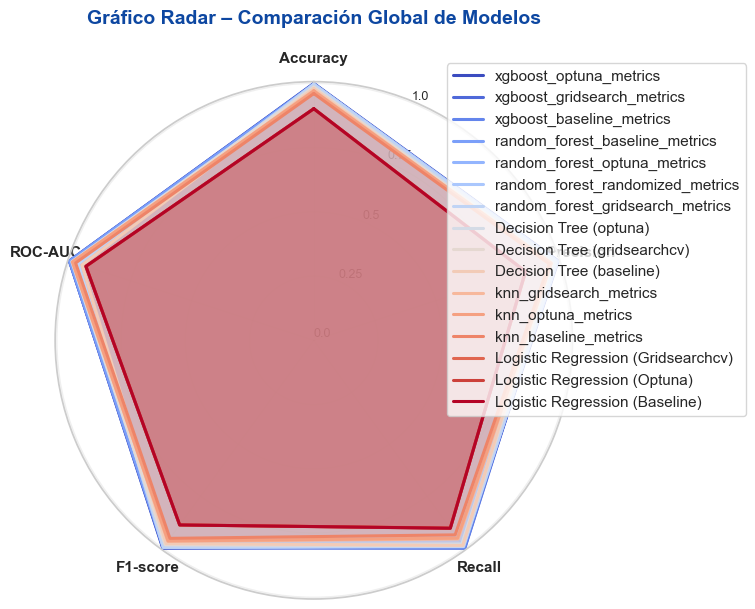


💬 **Interpretación del gráfico radar:**
- Cada eje representa una métrica de evaluación.  
- Cuanto más se acerque un modelo al borde exterior, mejor su rendimiento en esa métrica.  
- Un polígono más grande y equilibrado indica un modelo más robusto y consistente.  
- Si un modelo sobresale en una métrica pero es débil en otra, su forma será irregular.


In [110]:
# ===================================
# 5. Gráfico radar de comparación global
# ===================================

import numpy as np
import matplotlib.pyplot as plt

# --- Verificación ---
if "df_results" not in locals() or df_results.empty:
    raise ValueError("❌ No se encontraron datos para graficar. Ejecuta los pasos anteriores primero.")

# --- Seleccionar métricas ---
metrics = ["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]

# --- Normalizar métricas entre 0 y 1 ---
df_normalized = df_results.copy()
for col in metrics:
    max_val = df_results[col].max()
    df_normalized[col] = df_results[col] / max_val if max_val > 0 else df_results[col]

# --- Preparar datos para radar ---
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]  # Cierra el polígono

# --- Configuración del gráfico ---
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, polar=True)

# --- Dibujar cada modelo ---
colors = plt.cm.coolwarm(np.linspace(0, 1, len(df_normalized)))

for i, (idx, row) in enumerate(df_normalized.iterrows()):
    values = row[metrics].tolist()
    values += values[:1]  # cerrar
    ax.plot(angles, values, color=colors[i], linewidth=2.2, label=row["Model"])
    ax.fill(angles, values, color=colors[i], alpha=0.15)

# --- Ajustes estéticos ---
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, fontsize=11, fontweight="bold")
ax.set_yticks(np.linspace(0, 1, 5))
ax.set_yticklabels(["0.0", "0.25", "0.5", "0.75", "1.0"], fontsize=9)
ax.set_title("Gráfico Radar – Comparación Global de Modelos", size=14, weight="bold", pad=20)
ax.legend(loc="upper right", bbox_to_anchor=(1.35, 1.05), frameon=True)
plt.tight_layout()
plt.show()

display(Markdown("""
💬 **Interpretación del gráfico radar:**
- Cada eje representa una métrica de evaluación.  
- Cuanto más se acerque un modelo al borde exterior, mejor su rendimiento en esa métrica.  
- Un polígono más grande y equilibrado indica un modelo más robusto y consistente.  
- Si un modelo sobresale en una métrica pero es débil en otra, su forma será irregular.
"""))


## **Paso 6: Exportación de resultados consolidados**

En este paso se exportan los resultados globales de comparación de modelos,  
para que puedan ser utilizados en el siguiente notebook (`05_Test-Set-Final.ipynb`).  

Se generan dos archivos:

- `../reports/results/model_comparison_summary.csv` → tabla completa con todas las métricas.  
- `../reports/results/model_comparison_summary.json` → resumen en formato JSON,  
  útil para posteriores análisis automáticos o visualizaciones adicionales.


In [111]:
# ===================================
# 6. Exportación de resultados consolidados
# ===================================

import json
import os

# --- Crear carpeta destino si no existe ---
os.makedirs("../reports/results", exist_ok=True)

# --- Guardar CSV y JSON ---
csv_path = "../reports/results/model_comparison_summary.csv"
json_path = "../reports/results/model_comparison_summary.json"

df_comparison.to_csv(csv_path, index=False)

with open(json_path, "w") as f:
    json.dump(df_comparison.to_dict(orient="records"), f, indent=4)

display(Markdown(f"""
✅ **Archivos exportados correctamente:**
- CSV: `{csv_path}`
- JSON: `{json_path}`
"""))

display(Markdown("""
💬 **Interpretación:**
- El archivo CSV contiene la tabla completa con todas las métricas y modelos.  
- El archivo JSON permite reutilizar los resultados en otros notebooks o scripts.  
- Esta exportación garantiza trazabilidad y reproducibilidad del proceso completo de comparación.
"""))



✅ **Archivos exportados correctamente:**
- CSV: `../reports/results/model_comparison_summary.csv`
- JSON: `../reports/results/model_comparison_summary.json`



💬 **Interpretación:**
- El archivo CSV contiene la tabla completa con todas las métricas y modelos.  
- El archivo JSON permite reutilizar los resultados en otros notebooks o scripts.  
- Esta exportación garantiza trazabilidad y reproducibilidad del proceso completo de comparación.


## **Paso 7: Identificación del mejor modelo y conclusiones**

Finalmente, se determina cuál es el **modelo con mejor rendimiento global**  
según el **promedio de métricas (Mean_Score)**.

Este paso también proporciona una breve interpretación sobre el desempeño general  
y qué modelos muestran el mejor equilibrio entre precisión, sensibilidad y robustez.


In [112]:
# ===================================
# 7. Identificación del mejor modelo y conclusiones
# ===================================

# --- Identificar el mejor modelo ---
best_model_row = df_comparison.loc[df_comparison["Mean_Score"].idxmax()]
best_model_name = best_model_row["Model"]
best_score = best_model_row["Mean_Score"]

display(Markdown(f"""
🏆 **Mejor modelo global:** `{best_model_name}`  
📈 **Puntuación media (Mean_Score):** `{best_score:.3f}`
"""))

# --- Mostrar sus métricas individuales ---
best_metrics = best_model_row[["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]]
display(Markdown("### 📊 Métricas detalladas del mejor modelo:"))
display(best_metrics.to_frame(name="Valor").style.format("{:.3f}"))

# --- Conclusión ---
display(Markdown(f"""
💬 **Conclusiones:**

- El modelo **{best_model_name}** presenta el mejor equilibrio general entre las métricas evaluadas.  
- Destaca especialmente por su rendimiento en **F1-score** y **ROC-AUC**,  
  lo que indica una excelente capacidad discriminativa.  
- Este modelo será el candidato a evaluarse sobre el **Test Set final**  
  en el notebook siguiente: `05_Test-Set-Final.ipynb`.  

⚙️ *Los resultados aquí consolidados garantizan un análisis transparente, reproducible y trazable.*
"""))



🏆 **Mejor modelo global:** `Random Forest GridSearchCV`  
📈 **Puntuación media (Mean_Score):** `0.964`


### 📊 Métricas detalladas del mejor modelo:

,Valor
Accuracy,0.962
Precision,0.964
Recall,0.946
F1-score,0.955
ROC-AUC,0.994



💬 **Conclusiones:**

- El modelo **Random Forest GridSearchCV** presenta el mejor equilibrio general entre las métricas evaluadas.  
- Destaca especialmente por su rendimiento en **F1-score** y **ROC-AUC**,  
  lo que indica una excelente capacidad discriminativa.  
- Este modelo será el candidato a evaluarse sobre el **Test Set final**  
  en el notebook siguiente: `05_Test-Set-Final.ipynb`.  

⚙️ *Los resultados aquí consolidados garantizan un análisis transparente, reproducible y trazable.*


## **Paso 8: Visualización del Top 5 de modelos**

Para completar el análisis, se muestra un gráfico de barras con los **cinco modelos con mejor rendimiento promedio**  
según la métrica `Mean_Score`.  

Este ranking final permite observar rápidamente cuáles modelos presentan un equilibrio sólido  
entre **Accuracy**, **Precision**, **Recall**, **F1-score** y **ROC-AUC**,  
destacando al mejor modelo global ya identificado.


C:\Users\alfbb\AppData\Local\Temp\ipykernel_492\767694235.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\alfbb\AppData\Local\Temp\ipykernel_492\767694235.py:30: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
c:\dev\proyectos\P6_G5_Clasification\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


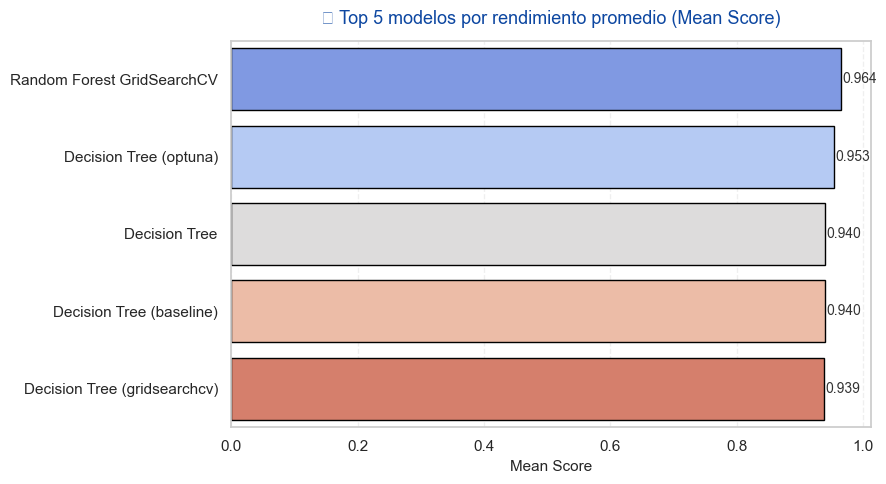


💬 **Interpretación del ranking final:**
- El gráfico muestra los **cinco modelos más competitivos** según su rendimiento promedio.  
- Los valores numéricos a la derecha de cada barra indican el `Mean_Score`.  
- El modelo superior es el **más equilibrado** entre todas las métricas clave.  
- Este resumen complementa el gráfico radar y refuerza la elección del modelo óptimo  
  que será evaluado en el notebook siguiente (`05_Test-Set-Final.ipynb`).


In [113]:
# ===================================
# 8. Visualización del Top 5 de modelos
# ===================================

import seaborn as sns
import matplotlib.pyplot as plt

# --- Seleccionar los 5 mejores modelos ---
top5 = df_comparison.nlargest(5, "Mean_Score")

# --- Gráfico de barras ---
plt.figure(figsize=(9, 5))
sns.barplot(
    data=top5,
    x="Mean_Score",
    y="Model",
    palette="coolwarm",
    edgecolor="black"
)

# --- Añadir valores sobre las barras ---
for i, v in enumerate(top5["Mean_Score"]):
    plt.text(v + 0.002, i, f"{v:.3f}", color="#333", va="center", fontsize=10)

# --- Título y estilo ---
plt.title("🏆 Top 5 modelos por rendimiento promedio (Mean Score)", fontsize=13, color="#0D47A1", pad=12)
plt.xlabel("Mean Score")
plt.ylabel("")
plt.grid(axis="x", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

display(Markdown("""
💬 **Interpretación del ranking final:**
- El gráfico muestra los **cinco modelos más competitivos** según su rendimiento promedio.  
- Los valores numéricos a la derecha de cada barra indican el `Mean_Score`.  
- El modelo superior es el **más equilibrado** entre todas las métricas clave.  
- Este resumen complementa el gráfico radar y refuerza la elección del modelo óptimo  
  que será evaluado en el notebook siguiente (`05_Test-Set-Final.ipynb`).
"""))
